![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M').astype(int))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price'].values
X = data.drop(['Price'], axis=1).values

In [4]:
X.shape

(10495, 9)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# importar librerías
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean())**2)

def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y[filter_l]
    y_r = y[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    mse_total = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    weighted_mse = (n_l / (n_l + n_r) * mse_l) + (n_r / (n_l + n_r) * mse_r)

    return mse_total - weighted_mse

# La función best_split permanece bastante similar, pero cambiamos la llamada a gini_impurity por mse_impurity
def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    # Para todas las varibles
    for j in features:

        splits = np.percentile(X[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            gain = mse_impurity(X[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y[:1], level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X[:, j] < split
    X_l, y_l = X[filter_l], y[filter_l]
    X_r, y_r = X[~filter_l], y[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

def tree_predict(X, tree):

    predicted = np.ones(X.shape[0]) * tree['y_pred']

    # Revisar si es el nodo final
    if tree['split'] != -1:

        j, split = tree['split']
        filter_l = (X[:, j] < split)

        if any(filter_l):
            predicted[filter_l] = tree_predict(X[filter_l], tree['sl'])
        if any(~filter_l):
            predicted[~filter_l] = tree_predict(X[~filter_l], tree['sr'])

    return predicted

la mejor profundidad encontrada con base en las evaluadas fue: 8
el mejor RMSE encontrado fue: 1624.788926276523
el mejor MAE encontrado fue: 1194.1069137955046


Text(0, 0.5, 'RMSE de árbol')

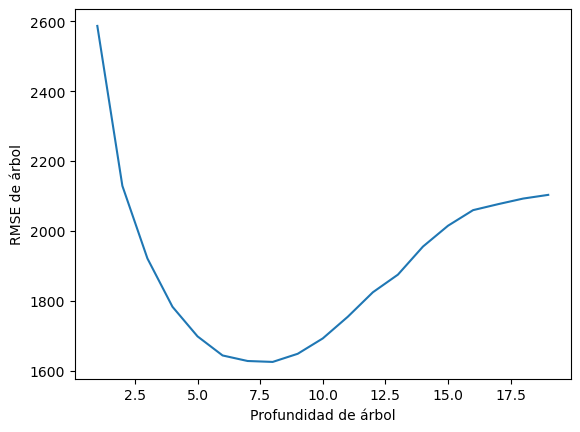

In [ ]:
vec_arbol_manual = []
vec_prof = []
mejor_profundidad = 0
mejor_arbol = None
mejor_RMSE = None
mejor_MAE = None
for i in range (1,20):

    tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=i, num_pct=10)

    prediction_tree = tree_predict(X_test, tree)
    RMSE_tree_manual = np.sqrt(np.average(np.square(prediction_tree - y_test)))
    MAE_tree_manual = np.average(np.abs(prediction_tree-y_test))
    # print('RMSE', RMSE_tree_manual)
    # print('MAE', MAE_tree_manual)
    vec_arbol_manual.append(RMSE_tree_manual)
    vec_prof.append(i)
    if mejor_RMSE == None or mejor_RMSE > RMSE_tree_manual:
        mejor_RMSE = RMSE_tree_manual
        mejor_MAE = MAE_tree_manual
        mejor_arbol = tree
        mejor_profundidad = i

print(f'la mejor profundidad encontrada con base en las evaluadas fue: {mejor_profundidad}')
print(f'el mejor RMSE encontrado fue: {mejor_RMSE}')
print(f'el mejor MAE encontrado fue: {mejor_MAE}')

plt.figure()
plt.plot(vec_prof,vec_arbol_manual)
plt.xlabel('Profundidad de árbol')
plt.ylabel('RMSE de árbol')

Se probó un árbol de decision para regresion, se evaluaron profundidades entre 1 y 20 obteniendo los siguientes resultados:
* La profundidad óptima para el árbol de decisión es 8.
* El menor RMSE obtenido es 1624.79, que se alcanza con un árbol de profundidad 8.
* El mejor MAE (Error Absoluto Medio) obtenido es 1194.11

Complejidad vs. Rendimiento: El gráfico muestra un patrón claro donde el RMSE disminuye a medida que la profundidad del árbol aumenta, hasta un punto óptimo de profundidad 8. Después de este punto, el RMSE comienza a aumentar, lo que sugiere que profundidades mayores a 8 podrían estar resultando en sobreajuste.

Punto Óptimo de Profundidad: La profundidad de 8 se presenta como el equilibrio entre un modelo demasiado simple y uno excesivamente complejo. Esto sugiere que en este nivel, el árbol es lo suficientemente complejo para capturar la relación subyacente en los datos sin capturar demasiado ruido (sobreajustar).



### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# importar librerías
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Árbol 1 tiene un RMSE: 1679.5620471420725
Árbol 2 tiene un RMSE: 1646.344358874213
Árbol 3 tiene un RMSE: 1672.207748594909
Árbol 4 tiene un RMSE: 1650.1799770715272
Árbol 5 tiene un RMSE: 1658.3483684035027
Árbol 6 tiene un RMSE: 1636.4471646134082
Árbol 7 tiene un RMSE: 1642.3200427715242
Árbol 8 tiene un RMSE: 1643.0632657177364
Árbol 9 tiene un RMSE: 1623.113058924117
Árbol 10 tiene un RMSE: 1645.345175003141
Ensamble tiene un RMSE: 1559.847016341425


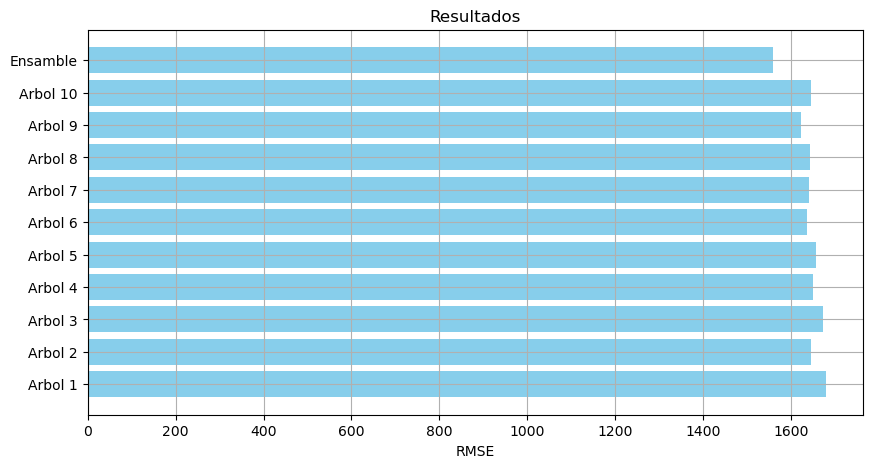

In [ ]:
def bagging_function (X_train, y_train, X_test, y_test, n_trees=10):

    np.random.seed(1)

    n_samples = X_train.shape[0]
    n_B = n_trees

    samples = [np.random.choice(a=X_train.shape[0], size=n_samples, replace=True) for _ in range(n_B)]

    # DataFrame para guardar las predicciones de cada árbol
    y_pred = pd.DataFrame(index=range(y_test.shape[0]), columns=range(n_B))

    # Entrenamiento de un árbol sobre cada muestra bootstrap y predicción sobre los datos de test
    for i, sample in enumerate(samples):
        X_train_sampled = X_train[sample, :]  # Usar datos muestreados sin alterar X_train original
        y_train_sampled = y_train[sample]      # Usar datos muestreados sin alterar y_train original
        tree = tree_grow(X_train_sampled, y_train_sampled, level=0, min_gain=0.001, max_depth=8, num_pct=10)
        y_pred.iloc[:, i] = tree_predict(X_test, tree)

    resultados = {}
    # Cálculo del error cuadrático medio para cada árbol y el ensamble
    for i in range(n_B):
        mse = mean_squared_error(y_test, y_pred.iloc[:, i])
        print('Árbol', i+1, 'tiene un RMSE:', np.sqrt(mse))
        resultados[f'Arbol {i+1}'] = np.sqrt(mse)

    # Promedio de las predicciones de todos los árboles
    ensemble_pred = y_pred.mean(axis=1)
    ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    print('Ensamble tiene un RMSE:', ensemble_rmse)
    resultados['Ensamble'] = np.sqrt(mean_squared_error(y_test, ensemble_pred))

    plt.figure(figsize=(10, 5))
    plt.barh(list(resultados.keys()), list(resultados.values()), color='skyblue')
    plt.xlabel('RMSE')
    plt.title('Resultados')
    plt.grid(True)
    plt.show()

bagging_function (X_train, y_train, X_test, y_test, n_trees=10)

Al implementar un modelo de bagging con 10 árboles de decisión, cada uno con la profundidad óptima previamente determinada de 8, se observan los siguientes resultados para el RMSE de cada árbol individual y del ensamble completo:

#### Resultados Individuales:
* Los RMSEs de los árboles individuales varían entre 1623.11 y 1679.56.
* Existe una variabilidad en el rendimiento entre los árboles individuales, lo que es esperable ya que cada árbol se entrena en una submuestra diferente del conjunto de datos.

#### Resultado del Ensamble:
* El RMSE del ensamble de bagging es de 1559.847, que es considerablemente más bajo que el de cualquier árbol individual.
Conclusiones:

#### Mejora del Ensamble sobre Árboles Individuales:
* El uso del ensamble de bagging ha mejorado significativamente el rendimiento en comparación con los árboles individuales, lo que demuestra la eficacia de la técnica de bagging para reducir la varianza del modelo y mejorar la precisión de las predicciones.

#### Reducción del Sobreajuste:
* Aunque cada árbol individual podría estar sobreajustado a su submuestra particular del conjunto de datos, la agregación de sus predicciones ayuda a mitigar este efecto, ya que las predicciones de los árboles pueden divergir, cancelándose los errores entre sí.

#### Consistencia con la Teoría:
* Estos resultados están en línea con la teoría detrás de los métodos de ensamble, que sugiere que combinar múltiples modelos puede conducir a un mejor rendimiento general, dado que los modelos individuales son suficientemente diversos y, preferiblemente, no correlacionados.

#### Validación del Modelo:
* El RMSE del ensamble es también mejor que el mejor RMSE (1624.79) del árbol de decisión individual con profundidad óptima encontrado previamente. Esto sugiere que el ensamble no solo es más robusto sino también más efectivo para el conjunto de datos utilizado.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# importar librerías
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# definir el objeto de ensamblaje con 10 estimadores y max_features
# para los arboles individuales, se usan los mismos parametros del punto anterior
# se compara todos los features vs log (features)
lista_features=[X_train.shape[1], int(np.log(X_train.shape[1]))]
lista_rmse=[]
for i in lista_features:
    mod = BaggingRegressor(DecisionTreeRegressor(max_depth=8, random_state=123), n_estimators=10,
                        max_features=i, bootstrap=True, oob_score=True, random_state=42)
    # entrenar el modelo y predecir
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    # calcular el rmse
    lista_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print("Ensamblaje usando todos los predictores")
print("Features: ", lista_features[0])
print("RMSE: ", lista_rmse[0])
print("\nEnsamblaje usando log(features)")
print("Features: ", lista_features[1])
print("RMSE: ", lista_rmse[1])

Ensamblaje usando todos los predictores
Features:  9
RMSE:  1572.312966564161

Ensamblaje usando log(features)
Features:  2
RMSE:  2768.3504147769763


El uso de las librerías de sklearn para ensambles permite, en primer lugar, verificar los resultados obtenidos mediante bagging manual usando todos los predictores X. De forma manual, se obtuvo un valor de RMSE para el ensamblaje muy cercano a aquel obtenido mediante librerías. De igual forma, se observa que cuando se emplea un número reducido de predictores `max_features=log(n_features)`, el RMSE del modelo aumenta de forma significativa, un 76% respecto al original, para ser exactos.

Esto es consistente con lo esperado, ya que el nuevo modelo cuenta con mucha menos información que el original (2 variables predictivas de 9 disponibles). Adicionalmente, a diferencia de random forest, un modelo bagging siempre elige la variable que ofrece el mejor split disponible, por lo cual con sólamente 2 variables predictivas disponibles, va a haber una alta correlación entre las predicciones de los árboles individuales, limitando los beneficios de un ensamblaje.

A modo ilustrativo, se estudia el efecto de variar el parámetro `max_features` sobre el desempeño del modelo.


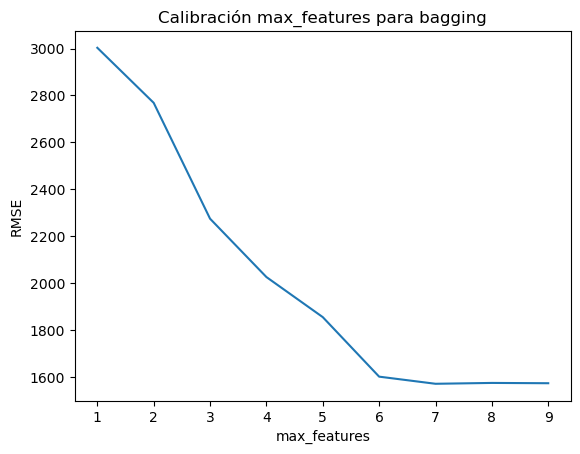

In [ ]:
features=np.arange(1,10) #numero de features
lista_rmse=[]
for i in features:
    mod = BaggingRegressor(DecisionTreeRegressor(max_depth=8, random_state=123), n_estimators=10,
                        max_features=i, bootstrap=True, oob_score=True, random_state=42)
    # entrenar el modelo y predecir
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    # calcular el rmse
    lista_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# graficar
plt.plot(features, lista_rmse)  # Aquí usamos mse_scores en lugar de accuracy_scores
plt.xlabel('max_features')
plt.ylabel('RMSE')  # Cambiado de 'Accuracy' a 'MSE' porque estamos tratando con regresión
plt.title('Calibración max_features para bagging')
plt.show()


Se observa que, para el conjunto de datos actual en un modelo bagging, es preferible contar con todos los predictores a no hacerlo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# importar librerías
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [ ]:
# Ajustar el número de árboles a 100
n_estimators = 100

# Definición de modelo Random Forest para un problema de regresión
rf = RandomForestRegressor()

# Evaluación del desempeño del modelo usando la función cross_val_score
# Utilizamos neg_mean_squared_error para obtener el error cuadrático medio en forma negativa.
mse_scores = cross_val_score(rf, X, y, cv=10, scoring='neg_mean_squared_error')

# Asegurándonos de que mse_scores es un arreglo NumPy para las operaciones matemáticas
mse_scores = np.array(mse_scores)

# Convertimos los errores a positivos y calculamos la raíz cuadrada para obtener RMSE.
rmse_scores = np.sqrt(-mse_scores)

# Describimos los resultados para obtener estadísticas como la media y la desviación estándar.
scores_description = pd.Series(rmse_scores).describe()

# Imprimir desempeño
print('Desempeño del modelo Random Forest (RMSE):')
print(scores_description)

Desempeño del modelo Random Forest (RMSE):
count      10.000000
mean     1744.951160
std        52.080705
min      1685.985056
25%      1698.155198
50%      1737.660163
75%      1789.330212
max      1815.752541
dtype: float64


### Interpretación de los Resultados

Los resultados del desempeño del modelo RandomForestRegressor evaluado mediante cross_val_score utilizando RMSE (Root Mean Squared Error) como la métrica muestran las siguientes estadísticas:

**Count**: Hay 10 valores de RMSE, lo que indica que se realizó una validación cruzada de 10 pliegues. Esto significa que el conjunto de datos se dividió en 10 partes, entrenando el modelo en 9 de ellas y validándolo en la restante en cada iteración.

**Mean**: El valor medio del RMSE es de aproximadamente **1744.95**. Este es el promedio del error de las predicciones del modelo en comparación con los valores reales, expresado en las mismas unidades que la variable objetivo (Price en este caso). Un RMSE de 1744.95 sugiere que, en promedio, las predicciones del modelo se desvían alrededor de 1744.95 unidades del valor real.

**Std (Desviación Estándar)**: La desviación estándar de los valores de RMSE es de aproximadamente 52.08. Esto indica que hay una variabilidad relativamente pequeña en el rendimiento del modelo a través de los diferentes pliegues de la validación cruzada. Una desviación estándar más baja sugiere que el modelo es relativamente estable y su desempeño es consistente a través de diferentes subconjuntos del conjunto de datos.

**Min (Mínimo)**: El valor mínimo del RMSE es de aproximadamente 1685.99. Este es el mejor desempeño (el error más bajo) que el modelo ha logrado en cualquiera de los pliegues de la validación cruzada.

**25% (Primer Cuartil)**: El 25% de los valores de RMSE están por debajo de aproximadamente 1698.16. Esto significa que en al menos un cuarto de los pliegues, el modelo logró un RMSE igual o menor que este valor.

**50% (Mediana)**: La mediana de los valores de RMSE es de aproximadamente 1737.66, lo que sugiere que la mitad de los valores de RMSE están por debajo de este punto y la otra mitad por encima. La mediana proporciona una buena indicación del desempeño central del modelo.

**75% (Tercer Cuartil)**: El 75% de los valores de RMSE están por debajo de aproximadamente 1789.33. Esto indica que en la mayoría de los pliegues, el modelo no superó este nivel de error.

**Max (Máximo)**: El valor máximo del RMSE es de aproximadamente 1815.75, mostrando el peor caso de desempeño en un pliegue particular de la validación cruzada.

### Evaluación del modelo con los datos test

In [ ]:
# Creación del modelo Random Forest para regresión
rf = RandomForestRegressor(random_state=42)

# Entrenamiento del modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Realización de predicciones sobre el conjunto de test
y_pred = rf.predict(X_test)

# Cálculo del MSE con las predicciones del conjunto de test
mse_test = mean_squared_error(y_test, y_pred)

# Cálculo del RMSE con las predicciones del conjunto de test
rmse_test = np.sqrt(mse_test)

# Impresión del RMSE
print(f'RMSE en el conjunto de test: {rmse_test}')

RMSE en el conjunto de test: 1765.4118259983413


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Random Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# importar librerías
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

### Calibración parametro max_features

In [ ]:
feature_range = range(1, X.shape[1] + 1)

# Lista para almacenar el Root Mean Squared Error (RMSE) para cada valor de max_features
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestRegressor(n_estimators=100, max_features=feature, random_state=1, n_jobs=-1)
    # Calcular el RMSE directamente
    rmse = np.sqrt(-cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error').mean())
    rmse_scores.append(rmse)

# Encontrar el valor de max_features que minimiza el RMSE
best_feature = feature_range[np.argmin(rmse_scores)]
best_rmse = min(rmse_scores)

print(f'Mejor valor de max_features: {best_feature}')
print(f'RMSE con mejor max_features: {best_rmse}')

Mejor valor de max_features: 9
RMSE con mejor max_features: 1743.7146260210338


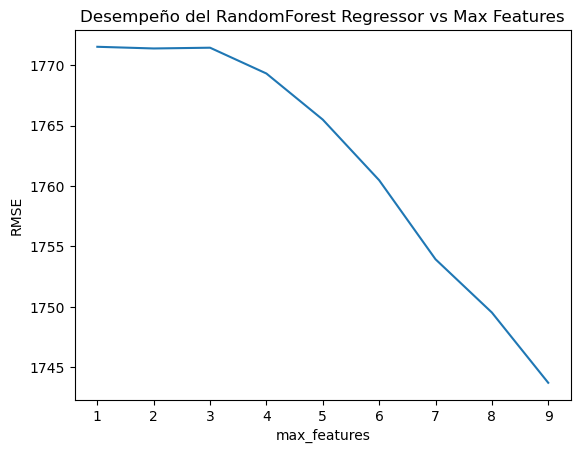

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')  # Cambiamos 'MSE' a 'RMSE'
plt.title('Desempeño del RandomForest Regressor vs Max Features')
plt.show()

### Interpretación y Contexto:

**Relevancia del RMSE**: Un RMSE de 1743.71 necesita ser contextualizado con respecto a la distribución de precios de los automóviles en el conjunto de datos. Si el rango de precios es bastante alto, este RMSE podría ser considerado aceptable. Por ejemplo, si los precios varían desde unos pocos miles hasta varios decenas de miles, un error promedio de 1743.71 podría no ser significativo. Sin embargo, si los precios están generalmente agrupados en un rango más estrecho cerca de este valor de RMSE, entonces el error puede ser considerado como más significativo.

**Optimización de max_features**: El hecho de que un valor específico de max_features minimice el RMSE sugiere que hay un balance entre suficiente aleatoriedad y la capacidad de hacer las mejores divisiones en cada nodo del árbol. Utilizar todos los atributos disponibles podría llevar a modelos que no generalizan bien (overfitting), mientras que usar muy pocos podría impedir que el modelo capture la estructura subyacente de los datos.

**Estrategia de Modelado**: La elección de 9 características como óptima podría ser útil para investigaciones futuras o ajustes del modelo. Por ejemplo, podrías explorar cuáles son esas 9 características más importantes o examinar si combinaciones específicas de características podrían mejorar aún más el rendimiento.

**Generalización**: Este valor de RMSE, obtenido a través de la validación cruzada, sugiere que el modelo generaliza razonablemente bien bajo la configuración actual. Sin embargo, siempre es prudente realizar pruebas adicionales, especialmente en nuevos conjuntos de datos o en subconjuntos del conjunto de datos que podrían diferir en características clave.

En conclusión, estos resultados proporcionan una guía útil para la configuración de hiperparámetros en modelos de bosques aleatorios y resaltan la importancia de ajustar max_features para mejorar la precisión de las predicciones en problemas de regresión.

### Calibración parametro n_estimators

In [ ]:
# el código toma varios minutos en completarse
estimator_range = range(10, 310, 10)

# Lista para almacenar el Root Mean Squared Error (RMSE) para cada valor de n_estimators
rmse_scores = []

# Uso de 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    mse_score = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    rmse_score = np.sqrt(mse_score)
    rmse_scores.append(rmse_score)

# Encontrar el valor de n_estimators que minimiza el RMSE
best_estimator = estimator_range[np.argmin(rmse_scores)]
best_rmse = min(rmse_scores)

print(f'Mejor número de estimadores: {best_estimator}')
print(f'RMSE con mejor número de estimadores: {best_rmse}')

Mejor número de estimadores: 300
RMSE con mejor número de estimadores: 1741.2642416096924


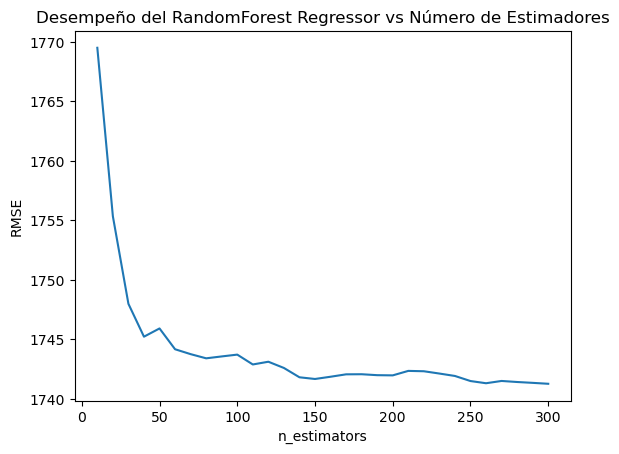

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')  # Cambiamos 'MSE' a 'RMSE'
plt.title('Desempeño del RandomForest Regressor vs Número de Estimadores')
plt.show()

#### Interpretación de los Resultados:

Número de Estimadores:

**Grado de error**: Un RMSE de 1741.26 puede considerarse alto o bajo dependiendo del rango y de la media de los precios de los automóviles en tu conjunto de datos. Si los precios varían ampliamente (por ejemplo, de 5000 a 50000), entonces un RMSE de 1741.26 puede ser relativamente pequeño y aceptable. Sin embargo, si los precios de los coches son generalmente más bajos o están agrupados alrededor de un valor menor, este RMSE puede ser significativo.

**Optimización del modelo**: Si bien en 300 se obtiene el valor óptimo del MSE, se observa que otorga una mejora muy leve respecto a 100 estimadores. La elección del mejor parámetro debe ser un compromiso entre precisión y gasto computacional, por lo cual para esta aplicación se considera que 100 es un valor óptimo.

**Generalización del modelo**: Un bajo RMSE en validación cruzada indica que el modelo es capaz de generalizar bien desde el conjunto de entrenamiento al conjunto de validación. Sin embargo, es esencial validar esto en un conjunto de datos de prueba independiente para confirmar que el modelo no está sobreajustado.

En resumen, un RMSE de 1741.26 con 300 estimadores muestra que el modelo tiene un cierto nivel de precisión y es capaz de hacer predicciones con un error promedio de esa magnitud. La evaluación de si este nivel de error es aceptable depende en última instancia del contexto específico de uso y de las expectativas para el modelo.

### Calibración parametro max_depth

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 31)  # Probando profundidades desde 1 hasta 30

# Definición de lista para almacenar el Root Mean Squared Error (RMSE) promedio para cada valor de max_depth
rmse_scores_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=1, n_jobs=-1)
    mse_score_depth = -cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    rmse_score_depth = np.sqrt(mse_score_depth)  # Calculando el RMSE
    rmse_scores_depth.append(rmse_score_depth)

# Encontrar el valor de max_depth que minimiza el RMSE
best_depth = depth_range[np.argmin(rmse_scores_depth)]
best_rmse_depth = min(rmse_scores_depth)

print(f'Mejor profundidad: {best_depth}')
print(f'RMSE con la mejor profundidad: {best_rmse_depth}')

Mejor profundidad: 8
RMSE con la mejor profundidad: 1540.0696909656588


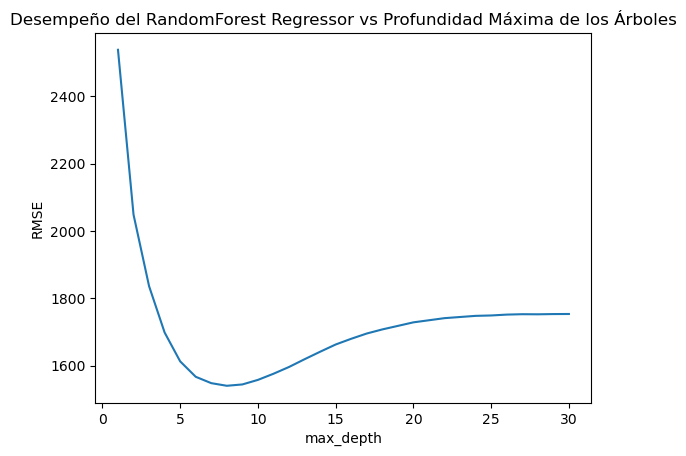

In [ ]:
# Suponiendo que rmse_scores_depth contiene los valores del RMSE para cada valor de max_depth
# y que depth_range contiene los valores de max_depth probados

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, rmse_scores_depth)  # Usamos rmse_scores_depth en lugar de mse_scores_depth
plt.xlabel('max_depth')  # Aseguramos que el eje X esté correctamente etiquetado como 'max_depth'
plt.ylabel('RMSE')  # Cambiamos 'MSE' a 'RMSE' porque estamos tratando con RMSE
plt.title('Desempeño del RandomForest Regressor vs Profundidad Máxima de los Árboles')
plt.show()

#### Interpretación de los Resultados:

Optimal Tree Depth:

Una profundidad máxima de 8 es el equilibrio encontrado por el modelo entre ser demasiado simple y demasiado complejo. Esto sugiere que a esta profundidad, los árboles son lo suficientemente detallados para capturar las relaciones subyacentes en los datos sin caer en el sobreajuste.

Profundidades menores a 8 probablemente fueron insuficientes para capturar la complejidad necesaria, mientras que profundidades mayores a 8 no mejoraron el rendimiento, posiblemente comenzando a modelar el ruido como señal (overfitting).

**Magnitud del Error**: Un RMSE de 1540.06 necesita ser contextualizado con respecto al rango de precios de los automóviles en el conjunto de datos. Si, por ejemplo, los precios de los coches varían principalmente entre 5000 y 50000, entonces un RMSE de aproximadamente 1540.06 podría considerarse relativamente pequeño y, por lo tanto, indicativo de un buen rendimiento del modelo. Sin embargo, si la mayoría de los precios están muy cerca de este valor de RMSE, entonces el error puede ser más significativo.

**Comparación con otros modelos**: Este RMSE es útil para comparar la efectividad del modelo RandomForest con otros modelos predictivos que podrías estar considerando. Si otros modelos proporcionan un RMSE significativamente más bajo, podrían ser preferibles dependiendo de otros factores como la complejidad del modelo y el tiempo de entrenamiento.

**Validación del Modelo**: Este valor también sugiere que el modelo generaliza razonablemente bien, dado que este RMSE se obtiene a través de una técnica de validación cruzada, lo que implica que el modelo no está sobreajustado a un subconjunto particular de datos.

**Implicaciones Prácticas**: En el contexto práctico, un administrador de flotas de vehículos o un revendedor podría usar este modelo para estimar precios de coches con un margen de error de aproximadamente 1540.06, lo que puede ser totalmente aceptable para decisiones de compra o venta rápidas.

En conclusión, un RMSE de 1540.06 sugiere que el modelo de regresión con la profundidad óptima de los árboles está realizando predicciones con un nivel de precisión razonable, pero la adecuación de este nivel de precisión debe evaluarse en función de las necesidades específicas del negocio o del contexto de aplicación del modelo.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [6]:
# librerías
from sklearn import metrics
import numpy as np
from xgboost import XGBRegressor

In [7]:
xgb = XGBRegressor()
xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
# Entrenamiento y desempeño del modelo XGBRegressor

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# Calculo del MSE y el MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("El modelo XGBRegressor tiene un RMSE igual a " +str(rmse)+ " y un MAE igual a "+str(mae))

El modelo XGBRegressor tiene un RMSE igual a 1605.2355199928948 y un MAE igual a 1185.2272991506386


**Desempeño XGBoost sin calibrar**

Se ha entrenado un modelo XGBoost utilizando los conjuntos de datos X_train y y_train, correspondientes a un problema de regresión. Para evaluar el rendimiento del modelo, se calcularon dos métricas comunes: la raiz del Error Cuadrático Medio (RMSE) y el Error Absoluto Medio (MAE). Los resultados obtenidos sin ajustar ninguno de los parámetros de nuestro modelo fueron de 1605.2 para el RMSE y de 1185.2 para el MAE.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [9]:
# librerias
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

Primero, se analizan individualmente cada parámetro para evaluar cómo cada valor afecta el desempeño del modelo, utilizando el MSE como métrica de evaluación. Luego, se utiliza Grid Search para explorar y evaluar todos los parámetros en conjunto, determinando cuál configuración produce el mejor desempeño en términos de minimización del MSE.

In [ ]:
# Calibración del learning rate
# Creación de lista de valores para iterar sobre diferentes valores de learning rate
learning_rates = np.arange(0, 1.1, 0.1)
# Definición de lista para almacenar el MSE para cada valor de learning rate
MSE = []

# Uso de un 5-fold cross-validation para cada valor
for rate in learning_rates:
    xgb = XGBRegressor(learning_rate=rate, random_state=1)
    MSE.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    MSE= [abs(valor) for valor in MSE]

Text(0, 0.5, 'MSE')

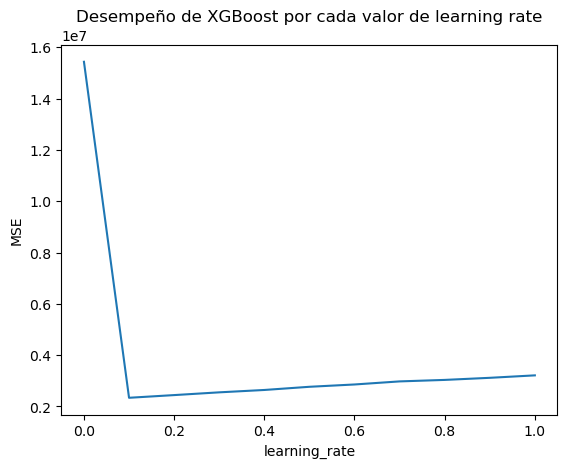

In [ ]:
plt.plot(learning_rates, MSE)
plt.title("Desempeño de XGBoost por cada valor de learning rate")
plt.xlabel('learning_rate')
plt.ylabel('MSE')

In [ ]:
# Calibración de gamma
gamma = np.arange(0, 1000, 100 )
MSE_2 = []
for valor in gamma:
    xgb = XGBRegressor(gamma=valor, random_state=1)
    MSE_2.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    MSE_2 = [abs(valor) for valor in MSE_2]

Text(0, 0.5, 'MSE')

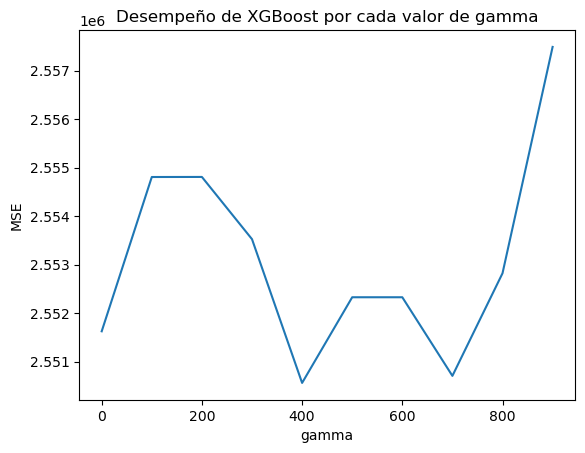

In [ ]:
plt.plot(gamma, MSE_2)
plt.title("Desempeño de XGBoost por cada valor de gamma")
plt.xlabel('gamma')
plt.ylabel('MSE')

In [ ]:
# Calibración del colsample_by_tree
samples = np.arange(0, 1.1, 0.1)
MSE_3 = []
for sample in samples:
    xgb = XGBRegressor(colsample_bytree=sample, random_state=1)
    MSE_3.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    MSE_3 = [abs(valor) for valor in MSE_3]

Text(0, 0.5, 'MSE_3')

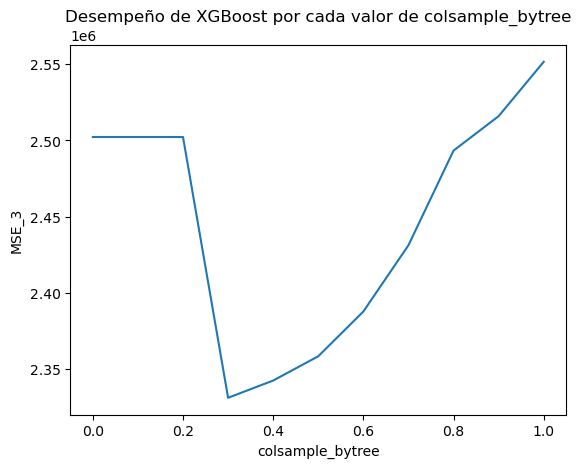

In [ ]:
plt.plot(samples, MSE_3)
plt.title("Desempeño de XGBoost por cada valor de colsample_bytree")
plt.xlabel('colsample_bytree')
plt.ylabel('MSE_3')

In [17]:
# Evaluamos el modelo con los mejores parámetros de acuerdo con lo anterior
xgb_calibrado_1 = XGBRegressor(colsample_bytree=0.3, learning_rate = 0.1, gamma = 400, random_state=1)
xgb_calibrado_1.fit(X_train, y_train)
y_pred = xgb_calibrado_1.predict(X_test)
mse_xgb_calibrado_1 = mean_squared_error(y_test, y_pred)
rsmse_xgb_calibrado_1 = np.sqrt(mse_xgb_calibrado_1)
mae_xgb_calibrado_1 = mean_absolute_error(y_test, y_pred)
print("El modelo XGB calibrado tiene un RMSE igual a " +str(rsmse_xgb_calibrado_1)+ " y un MAE igual a "+str(mae_xgb_calibrado_1))

El modelo XGB calibrado tiene un RMSE igual a 1561.7433058487443 y un MAE igual a 1151.7259872471764


In [18]:
# Calibrar modelo usando Grid Search
params = {
        'gamma': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        }

In [19]:
# librerias
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [22]:
folds = 3
xgb_2 = XGBRegressor(random_state = 1)
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1)
grid = GridSearchCV(estimator=xgb_2, param_grid=params, scoring='neg_mean_squared_error', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3 )
grid.fit(X_train, y_train)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)


Fitting 3 folds for each of 810 candidates, totalling 2430 fits

 All results:
{'mean_fit_time': array([0.19520267, 0.14253243, 0.17257396, 0.16140978, 0.15712317,
       0.17910298, 0.17970602, 0.1748848 , 0.14225475, 0.17107288,
       0.22437048, 0.28833453, 0.31486305, 0.23518729, 0.23361437,
       0.18500908, 0.16014345, 0.19077222, 0.16573389, 0.18313209,
       0.18453097, 0.16687512, 0.15974498, 0.18881178, 0.14461327,
       0.15442618, 0.15638439, 0.14969389, 0.16517099, 0.13999391,
       0.19147317, 0.17727343, 0.21422521, 0.14436014, 0.27443631,
       0.2415092 , 0.27645977, 0.27715778, 0.27264508, 0.29671931,
       0.28449917, 0.26615945, 0.23967894, 0.22531851, 0.24387002,
       0.25507061, 0.22076472, 0.2263008 , 0.25953468, 0.17632174,
       0.16039054, 0.16894404, 0.14641913, 0.16517909, 0.17571052,
       0.15604687, 0.16755493, 0.16253805, 0.16507665, 0.14912915,
       0.1582466 , 0.16597176, 0.13420979, 0.15721043, 0.1361262 ,
       0.16870602, 0.15410233, 0

In [28]:
# Definición del modelo XGBoost con los parámetros encontrados por GridSearch
xgb_calibrado_2 = XGBRegressor(colsample_bytree=0.5, learning_rate = 0.1, gamma = 1000, random_state=1)
xgb_calibrado_2.fit(X_train, y_train)
y_pred = xgb_calibrado_2.predict(X_test)
mse_xgb_calibrado_2 = mean_squared_error(y_test, y_pred)
mae_xgb_calibrado_2 = mean_absolute_error(y_test, y_pred)
rmse_xgb_calibrado_2 = np.sqrt(mse_xgb_calibrado_2)
print("El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a " +str(rmse_xgb_calibrado_2)+ " y un MAE igual a "+str(mae_xgb_calibrado_2))

El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a 1551.6777818375315 y un MAE igual a 1140.2852299714473


## Conclusiones
Como se comentó inicialmente, primero se hizo una calibración evaluando cada parámetro del modelo de manera individual y se escogió el valor de cada parámetro que minimizaba el MSE. Posteriormente, se estimó el modelo con los valores escogidos previamente y este arrojó un RMSE igual a 1561.7 y un MAE igual a 1151.7, lo cual representa una mejora respecto al modelo sin calibrar.

Luego, se uso Grid Search, que es una técnica que usa todos los posibles valores de los parámetros que se desean ajustar y evalua el rendimiento del modelo utilizando cada combinación de estos valores. Luego, selecciona la combinación de parámetros que produce el mejor rendimiento según una métrica de evaluación predefinida, que en este caso fue el MSE. El resultado usando los parámetros escogidos con esta técnica arrojó un RMSE igual a 1551.7 y un MAE igual a 1140.3, lo cual mejorá aún más el desempeño respecto a la calibración inicial. Esto nos indica que evaluar el desempeño de las combinaciones de los parámetros nos da un mejor resultado que evaluar cada parámetro de forma independiente.

Respecto al impacto de cada parámetro en el desempeño del modelo. A continuación se comenta sobre cada uno:

**Learning Rate**: Este parámetro controla la tasa de aprendizaje del modelo, es decir, cuánto contribuyen las actualizaciones de los árboles individuales a la construcción del modelo final. Un valor más bajo significa que el modelo se mueve más lentamente hacia la solución óptima, lo que puede resultar en un modelo más preciso y en el que existe menor riesgo de sobreajuste, pero que requiere más iteraciones para llegar a un buen resultado.

**Gamma**: Define la mínima reducción de pérdida requerida para cualquier actualización del árbol. Entonces, un valor más alto significa que se requerirá una mayor ganancia para que haya una división adicional  en el árbol, lo cual tambien reduce la probabilidad de sobreajuste.

**Colsample_bytree**: Controla la proporción de características que se seleccionan aleatoriamente para construir cada árbol. Un valor más bajo de  significa que se selecciona una menor cantidad de características para construir cada árbol, lo que puede reducir la varianza del modelo y tambien disminuye la probabilidad de sobreajuste. Por ende, un valor más alto puede aumentar la varianza pero reducir el sesgo del modelo.

La forma en como afecta el desempeño de nuestro modelo de forma especifica depende de nuestros datos. Usando los conjuntos X_train y y_train vemos que al aumentar la tasa de aprendizaje de nuestro modelo (sin tener en cuenta los demás parámetros)  no tenemos mejoras en el desempeño, es decir, nuestro modelo tiene un mejor desempeño cuando la contribución de cada árbol a la predicción final es más baja. En cuanto a gamma, no hay una forma clara en la que mejora el desempeño al aumentar o disminuir este valor. Finalmente, para colsample_bytree si es notorio que existe una disminución el MSE (mejora el desempeño) al aumentar la proporción de características a tener en cuenta, esto hasta cierto punto en el que el MSE empieza a aumentar considerablemente. Todo lo anterior nos muestra que es necesario evaluar diferentes valores de los parámetros para encontrar aquel que tenga el mejor equilibrio y genere un mejor desempeño.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [29]:
# importar librerías
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

Para realizar la comparación, se recuerdan los mejores resultados obtenidos para cada modelo mediante calibración:
* Random Forest: `max_features=9`, `n_estimators=100`, `max_depth=8`.
* XGBoost: `colsample_bytree= 0.5`, `gamma= 1000`, `learning_rate= 0.1`

RMSE Random Forest:  1564.7554015489497
RMSE XGBoost:  1551.6777818375315


Text(0.5, 1.0, 'Comparación RF y XGB Calibrados')

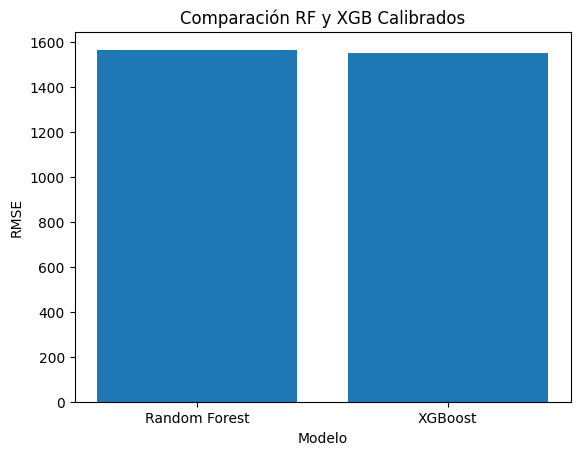

In [31]:
modelos=["Random Forest", "XGBoost"]
lista_rmse=[]

#modelo random forest
rf=RandomForestRegressor(max_features=9, n_estimators=100, max_depth=8, random_state=1)
rf.fit(X_train, y_train)
y_pred1=rf.predict(X_test)
rmse1=np.sqrt(mean_squared_error(y_test, y_pred1))
lista_rmse.append(rmse1)

#modelo xgboost
xgb=XGBRegressor(learning_rate=0.1, colsample_bytree=0.5, gamma=1000, random_state=1)
xgb.fit(X_train, y_train)
y_pred2=xgb.predict(X_test)
rmse2=np.sqrt(mean_squared_error(y_test, y_pred2))
lista_rmse.append(rmse2)

print("RMSE Random Forest: ", rmse1)
print("RMSE XGBoost: ", rmse2)

#graficar
plt.bar(modelos, lista_rmse)
plt.xlabel("Modelo")
plt.ylabel("RMSE")
plt.title("Comparación RF y XGB Calibrados")

En síntesis, se obtuvo un desempeño levemente mejor para el modelo XGBoost calibrado que para el Random Forest, según el RMSE (Root Mean Squared Error). A priori, esto es de esperarse, pues XGBoost es considerado el estado del arte en modelos de ensamblaje tipo Boosting. La mejora es de tan sólo el 0.8% respecto al desempeño del Random Forest, pero pequeñas mejoras pueden hacer grandes diferencias en contextos reales.

Dado que los modelos se construyen bajo modelos y parámetros distintos, es difícil hacer una comparación directa entre los dos que busque explicar las razones por las diferencias en desempeño. Adicionalmente, ambos modelos tienen alta capacidad predictiva, pero baja interpretabilidad.